In [28]:
import pandas as pd
from pathlib import Path
from src.mevpt import *
from src.scaling_helper import *
from src.mplstyle import set as set_mplstyle
from itertools import cycle
from IPython.utils import io
set_mplstyle("Fira Sans")

VAR = "DPT"
DATA_DOC_PATH = Path("./data/dataset_docs/")
OUTPUT_PATH = Path("./output/figures/")
OE_DIR = {"TMEAN": Path("./data/OE_tmean_era5/"), "DPT": Path("./data/OE_dpt_era5/")}
STATION_LIST = {"TMEAN": pd.read_csv(DATA_DOC_PATH / "pt_stations_ge30y_80pct_good.csv"), "DPT": pd.read_csv(DATA_DOC_PATH / "p_dpt_stations_ge30y_70pct_good.csv")}

COLORS = ["#0C5DA5", "lightcoral"]

In [5]:

def c_T(T, c0, beta_c):
    """Scale parameter as function of temperature with numerical stability"""
    # Clip beta_c * T to prevent overflow
    exponent = np.clip(beta_c * T, -700, 700)
    return c0 * np.exp(exponent)

def w_T(T, w0, beta_w):
    """Shape parameter as function of temperature with numerical stability"""
    # Clip beta_w * T to prevent overflow
    exponent = np.clip(beta_w * T, -700, 700)
    return w0 * np.exp(exponent)

def neg_log_likelihood_wT(params, x, T):
    """Negative log-likelihood with both parameters temperature-dependent"""
    c0, beta_c, w0, beta_w = params
    
    # Add small epsilon to prevent parameters from being exactly zero
    eps = 1e-12
    c0 = max(c0, eps)
    w0 = max(w0, eps)
    
    ct = c_T(T, c0, beta_c)
    wt = w_T(T, w0, beta_w)
    
    # Ensure ct and wt are positive
    ct = np.maximum(ct, eps)
    wt = np.maximum(wt, eps)
    
    # Ensure x is positive (additional safety check)
    x = np.maximum(x, eps)
    
    # Calculate log-likelihood components with numerical stability
    try:
        # Log terms
        log_wt = np.log(wt)
        log_ct = np.log(ct)
        
        # Ratio x/ct with clipping to prevent extreme values
        x_over_ct = np.clip(x / ct, eps, 1e10)
        log_x_over_ct = np.log(x_over_ct)
        
        # Power term with clipping to prevent overflow
        power_term = np.clip(x_over_ct ** wt, eps, 1e100)
        
        # Calculate log-likelihood
        log_likelihood = (
            log_wt - log_ct + 
            (wt - 1) * log_x_over_ct - 
            power_term
        )
        
        # Check for invalid values
        if not np.all(np.isfinite(log_likelihood)):
            return 1e10  # Return large penalty for invalid values
            
        return -np.sum(log_likelihood)
        
    except (OverflowError, ZeroDivisionError, ValueError):
        return 1e10  # Return large penalty for numerical errors

def neg_log_likelihood_w_const(params, x, T):
    """Negative log-likelihood with constant shape parameter"""
    c0, beta_c, w = params
    
    # Add small epsilon to prevent parameters from being exactly zero
    eps = 1e-12
    c0 = max(c0, eps)
    w = max(w, eps)
    
    ct = c_T(T, c0, beta_c)
    ct = np.maximum(ct, eps)
    
    # Ensure x is positive
    x = np.maximum(x, eps)
    
    try:
        # Log terms
        log_w = np.log(w)
        log_ct = np.log(ct)
        
        # Ratio x/ct with clipping
        x_over_ct = np.clip(x / ct, eps, 1e10)
        log_x_over_ct = np.log(x_over_ct)
        
        # Power term with clipping
        power_term = np.clip(x_over_ct ** w, eps, 1e100)
        
        # Calculate log-likelihood
        log_likelihood = (
            log_w - log_ct + 
            (w - 1) * log_x_over_ct - 
            power_term
        )
        
        # Check for invalid values
        if not np.all(np.isfinite(log_likelihood)):
            return 1e10
            
        return -np.sum(log_likelihood)
        
    except (OverflowError, ZeroDivisionError, ValueError):
        return 1e10

def exponential_reg_ML(sample, temp, initial_guess=None, wt=True, return_aic=False, 
                      max_iter=1000, tolerance=1e-8):
    """
    Fit Weibull distribution with temperature-dependent parameters using ML
    
    Parameters:
    -----------
    sample : array-like
        Sample data
    temp : array-like
        Temperature data
    initial_guess : list, optional
        Initial parameter guess
    wt : bool
        If True, shape parameter is temperature-dependent
    return_aic : bool
        If True, return AIC along with parameters
    max_iter : int
        Maximum iterations for optimization
    tolerance : float
        Convergence tolerance
    """
    
    # Filter positive samples and corresponding temperatures
    mask = sample > 0
    x = sample[mask]
    T = temp[mask]
    
    if len(x) == 0:
        raise ValueError("No positive samples found")
    
    # Suppress specific warnings during optimization
    with warnings.catch_warnings():
        warnings.filterwarnings('ignore', category=RuntimeWarning)
        
        if wt:
            # Both parameters temperature-dependent
            if initial_guess is None:
                # More conservative initial guess
                initial_guess = [np.mean(x), 0.01, 1.2, -0.001]
            
            # Tighter bounds to prevent extreme parameter values
            bnds = ((1e-6, 1e6), (-1, 1), (1e-6, 10), (-1, 1))
            
            # Try multiple optimization methods
            methods = ['L-BFGS-B', 'TNC', 'SLSQP']
            best_result = None
            best_nll = np.inf
            
            for method in methods:
                try:
                    result = minimize(
                        neg_log_likelihood_wT,
                        initial_guess,
                        args=(x, T),
                        method=method,
                        bounds=bnds,
                    )
                    
                    if result.success and result.fun < best_nll:
                        best_result = result
                        best_nll = result.fun
                        
                except Exception as e:
                    continue
            
            if best_result is None:
                raise RuntimeError("Optimization failed for all methods")
                
            result = best_result
            c0, beta_c, w0, beta_w = result.x
            
            cw_reg = {
                "c0": c0,
                "beta_c": beta_c,
                "w0": w0,
                "beta_w": beta_w,
            }
            
            if return_aic:
                k = len(initial_guess)
                nll = neg_log_likelihood_wT(result.x, x, T)
                
        else:
            # Constant shape parameter
            if initial_guess is None:
                initial_guess = [np.mean(x), 0.01, 1.2]
            
            bnds = ((1e-6, 1e6), (-1, 1), (1e-6, 10))
            
            result = minimize(
                neg_log_likelihood_w_const,
                initial_guess,
                args=(x, T),
                method="L-BFGS-B",
                bounds=bnds,
                options={'maxiter': max_iter, 'ftol': tolerance}
            )
            
            if not result.success:
                raise RuntimeError(f"Optimization failed: {result.message}")
            
            c0, beta_c, w = result.x
            
            # Fixed: Use correct variable names for constant w case
            cw_reg = {
                "c0": c0,
                "beta_c": beta_c,
                "w0": w,  # For constant case, store as 'w0':w, 'beta_w': 0 for ease of plotting
                "beta_w": 0
            }
            
            if return_aic:
                k = len(initial_guess)
                nll = neg_log_likelihood_w_const(result.x, x, T)
    
    if return_aic:
        aic = 2 * k + 2 * nll
        return cw_reg, aic
    else:
        return cw_reg

In [ ]:
from scipy.stats import gaussian_kde

def compute_aic(stations, d, var, data_dir):
    aic_wt_region, aic_w_const_region = [], []
    for stn_id in stations:
        df = load_data(stn_id, d, data_dir=data_dir)
        prcp, exg = df["PRCP"].values, df[var].values
        try:
            cw_scaling = scaling_analysis(prcp, exg, var, ci=True, ntimes=1000, n_bins=12)

            threshold = np.percentile(prcp, 10)
            c_reg = linregress(cw_scaling[var+"_med"], cw_scaling["c"])
            w_reg = linregress(cw_scaling[var+"_med"], np.log10(cw_scaling["w"]))

            initial_guess = [np.exp(c_reg.intercept), c_reg.slope, np.exp(w_reg.intercept) , w_reg.slope]
            _, aic_wt = exponential_reg_ML(prcp-threshold, exg, initial_guess=initial_guess, wt=True, return_aic=True)

            initial_guess_const = [np.exp(c_reg.intercept), c_reg.slope, cw_scaling["w"].mean()]
            _, aic_w_const = exponential_reg_ML(prcp-threshold, exg, initial_guess=initial_guess_const, wt=False, return_aic=True)
        except:
            print(f"Failed to process {stn_id}")
            continue

        aic_wt_region.append(aic_wt)
        aic_w_const_region.append(aic_w_const)
    return np.asarray(aic_wt_region), np.asarray(aic_w_const_region)


def aic_analysis(var):
    regions = [ 'BSk','BWk','Cfa','Csb','Dfa','Dfb']
    aic_wt = {region: {} for region in regions}
    aic_w_const = {region: {} for region in regions}

    for i, region in enumerate(regions):
        for d in ["1h", "24h"]:
            stations = STATION_LIST[var].loc[STATION_LIST[var]["KG"] == region, "StnID"].values
            aic_wt_region, aic_w_const_region = compute_aic(stations, d, var, OE_DIR[var])
            aic_wt[region][d] = aic_wt_region
            aic_w_const[region][d] = aic_w_const_region
    return aic_wt, aic_w_const


def plot_aic_diff(aic_wt, aic_w_const, savedir=None):
    regions = [ 'BSk','BWk','Cfa','Csb','Dfa','Dfb']
    fig, axs = plt.subplots(2, 3, figsize=(8, 5), constrained_layout=True)
    axs = axs.flatten()
    color = ["steelblue", "lightcoral"]
    for i, region in enumerate(regions):
        for j, d in enumerate(["1h", "24h"]):
            # Positive values mean time-varying model is better
            aic_diff = np.array(aic_w_const[region][d]) - np.array(aic_wt[region][d])
            
            kde = gaussian_kde(aic_diff)
            x_range = np.linspace(aic_diff.min() - 1, aic_diff.max() + 1, 200)
            kde_values = kde(x_range)
            
            axs[i].fill_between(x_range, kde_values, alpha=0.2, color=color[j], zorder=1)
            axs[i].plot(x_range, kde_values, '-', alpha=0.7, color=color[j], linewidth=0.5, zorder=2)
            
            axs[i].scatter(aic_diff, np.zeros_like(aic_diff), 
                        alpha=0.7, color=color[j], s=20, zorder=3)
            axs[i].axvline(x=np.mean(aic_diff), color=color[j], linestyle='--', alpha=0.8, linewidth=2)

        
        axs[i].axvline(x=0, color='k', linestyle='-', alpha=0.7, linewidth=1)
        
        axs[i].set_title(region, fontsize=10)
        axs[i].set_xlabel('$\\text{AIC}_{w=\\text{const}}-\\text{AIC}_{w=w(T)}$')
        axs[i].set_ylabel('Density')
        ylim = axs[i].get_ylim()
        axs[i].set_ylim((ylim[0], ylim[1] + 0.3*(ylim[1] - ylim[0])))
        inset = plot_inset([region], axs[i], position=[0.6, 0.7, 0.35, 0.3])
    if savedir:
        fig.savefig(savedir / f"aic.pdf", dpi=300, format="pdf")
    plt.show()


In [6]:
aic_wt, aic_w_const = aic_analysis(VAR)

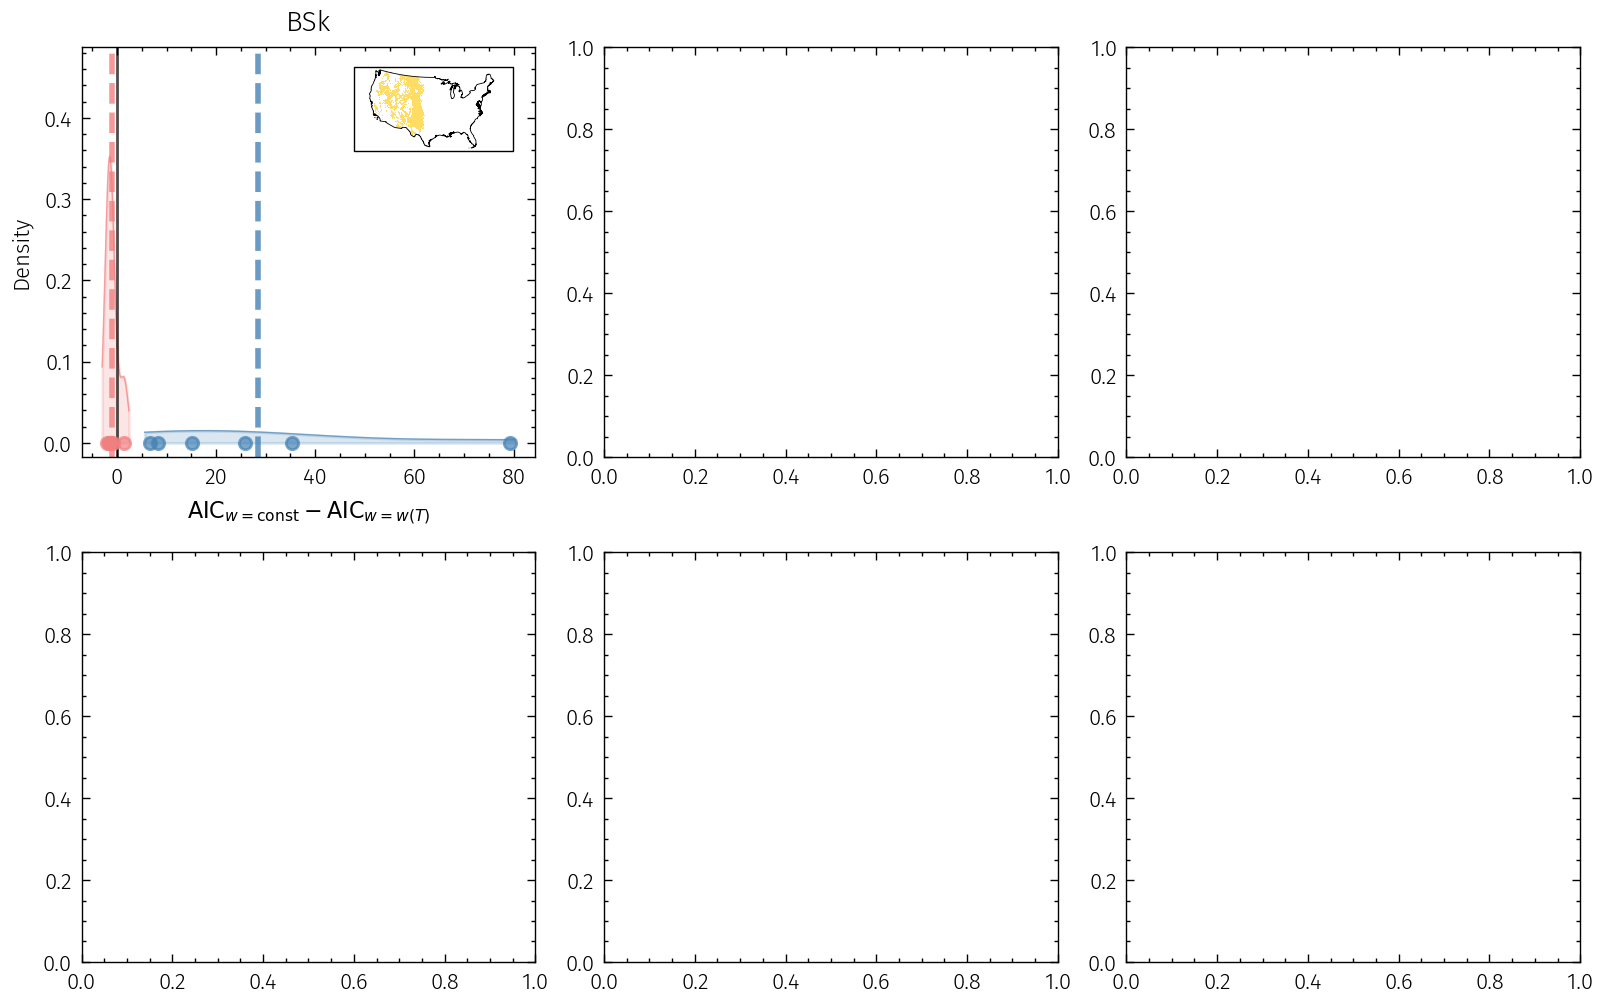

In [51]:
plot_aic_diff(aic_wt, aic_w_const)